In [1]:
# Install python-chess
!pip install -q chess

import os
import numpy as np
import chess
import chess.pgn
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from tqdm.notebook import tqdm

# Configure GPU Strategy
# -----------------------------------------------------------
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ Detected {len(gpus)} GPUs: {gpus}")
    except RuntimeError as e:
        print(e)

# Initialize Strategy for Multi-GPU
strategy = tf.distribute.MirroredStrategy()
print(f"✅ Number of devices: {strategy.num_replicas_in_sync}")

2026-01-21 22:35:20.986143: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769034921.008428     674 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769034921.015242     674 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769034921.033100     674 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769034921.033121     674 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769034921.033124     674 computation_placer.cc:177] computation placer alr

✅ Detected 2 GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
✅ Number of devices: 2


I0000 00:00:1769034924.900920     674 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1769034924.904834     674 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [3]:
# Constants
MAX_GAMES_TO_LOAD = 25000  # Adjust based on RAM availability
BATCH_SIZE_PER_REPLICA = 512
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
EPOCHS = 25
DATA_DIR = "lichess_games"

In [ ]:
def download_and_extract_data(years):
    os.makedirs(DATA_DIR, exist_ok=True)
    
    # 1. Generate Links
    links = []
    for year in years:
        # Standard Lichess Elite format: 2025-01 to 2025-12 (simplified logic)
        for i in range(1, 13):
            month = f"{i:02d}"
            url = f"https://database.nikonoel.fr/lichess_elite_{year}-{month}.zip"
            links.append(url)

    print(f"⬇️ Downloading {len(links)} files...")
    
    # 2. Download & Unzip
    for url in links:
        filename = os.path.basename(url)
        filepath = os.path.join(DATA_DIR, filename)
        
        # Download if not exists
        if not os.path.exists(filepath):
            !wget -q {url} -P {DATA_DIR}
            
        # Unzip
        # Note: We check if the unzipped .pgn exists to avoid re-unzipping
        pgn_name = filename.replace('.zip', '.pgn')
        if not os.path.exists(os.path.join(DATA_DIR, pgn_name)):
            print(f"Unzipping {filename}...")
            !unzip -q -o {filepath} -d {DATA_DIR}
            !rm {filepath} # Save space by deleting zip
            
    print("✅ Download and extraction complete.")

# Trigger Download (Example for late 2024/2025)
years = ["2023","2024"] 
download_and_extract_data(years)

In [11]:
# 1. Board Representation
def board_to_matrix(board: chess.Board):
    # 8x8x12 Matrix (6 piece types * 2 colors)
    matrix = np.zeros((8, 8, 12), dtype=np.float32)
    piece_map = board.piece_map()
    
    for square, piece in piece_map.items():
        row, col = divmod(square, 8)
        # 0-5 for White, 6-11 for Black
        piece_offset = 0 if piece.color == chess.WHITE else 6
        layer = piece.piece_type - 1 + piece_offset
        matrix[row, col, layer] = 1.0
        
    return matrix

# 2. PGN Loader
def load_games_and_vocab(data_dir, max_games):
    games = []
    moves_vocab = set()
    files = [f for f in os.listdir(data_dir) if f.endswith('.pgn')]
    
    print("📖 Reading PGN files...")
    count = 0
    
    for file in files:
        with open(os.path.join(data_dir, file)) as pgn_file:
            while count < max_games:
                try:
                    game = chess.pgn.read_game(pgn_file)
                except:
                    continue # Skip broken games
                    
                if game is None: break
                
                games.append(game)
                
                # Pre-scan for vocabulary
                for move in game.mainline_moves():
                    moves_vocab.add(move.uci())
                    
                count += 1
                if count % 1000 == 0:
                    print(f"Loaded {count} games...")
                    
    move_to_int = {move: i for i, move in enumerate(sorted(moves_vocab))}
    return games, move_to_int



In [ ]:
# Load Data
games_list, move_to_int = load_games_and_vocab(DATA_DIR, MAX_GAMES_TO_LOAD)
NUM_CLASSES = len(move_to_int)
print(f"✅ Loaded {len(games_list)} games.")
print(f"✅ Found {NUM_CLASSES} unique moves.")

In [6]:
def game_position_generator():
    """Yields (Board Matrix, Move Index) one by one."""
    for game in games_list:
        board = game.board()
        for move in game.mainline_moves():
            uci = move.uci()
            if uci in move_to_int:
                yield board_to_matrix(board), move_to_int[uci]
                board.push(move)

def create_dataset(generator, batch_size):
    output_signature = (
        tf.TensorSpec(shape=(8, 8, 12), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
    
    ds = tf.data.Dataset.from_generator(
        generator, 
        output_signature=output_signature
    )
    
    ds = ds.shuffle(10000)
    # DROP_REMAINDER=TRUE IS MANDATORY FOR MIRROREDSTRATEGY
    ds = ds.batch(batch_size, drop_remainder=True) 
    ds = ds.map(lambda x, y: (x, tf.one_hot(y, NUM_CLASSES)), 
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds



In [ ]:
# Create the optimized dataset
train_dataset = create_dataset(game_position_generator, GLOBAL_BATCH_SIZE)
print("✅ Dataset Pipeline Created")

In [6]:
def build_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # --- Feature Extraction (The "Eye" of the engine) ---
    # We can keep these filters high, they are cheap parameter-wise
    x = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)


    # --- Global Reasoning (The "Brain") ---
    x = layers.Flatten()(x) 
    # Now Flatten is 8*8*64 = 4096 (instead of 16384)
    
    x = layers.Dense(256)(x) # Reduced from 1024 to 512
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x) # Increased dropout to force generalization

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)



# ------------------------------------------------
# COMPILE AND TRAIN INSIDE SCOPE
# ------------------------------------------------
with strategy.scope():
    model = build_model((8, 8, 12), NUM_CLASSES)
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy', 
            tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_acc')
        ]
    )

model.summary()

# Train
history = model.fit(
    train_dataset,
    epochs=EPOCHS
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8, 8, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 8, 8, 64)       │         6,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1878)           │       482,646 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,662,678 (10.16 MB)

 Trainable params: 2,661,782 (10.15 MB)

 Non-trainable params: 896 (3.50 KB)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

I0000 00:00:1769035036.022494     722 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1769035036.080714     720 cuda_dnn.cc:529] Loaded cuDNN version 91002


2067/2067 ━━━━━━━━━━━━━━━━━━━━ 702s 334ms/step - accuracy: 0.1284 - loss: 4.8675 - top_5_acc: 0.3025
Epoch 2/25


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2067/2067 ━━━━━━━━━━━━━━━━━━━━ 705s 340ms/step - accuracy: 0.1966 - loss: 3.6358 - top_5_acc: 0.4455
Epoch 3/25
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 719s 346ms/step - accuracy: 0.2186 - loss: 3.4404 - top_5_acc: 0.4851
Epoch 4/25
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 702s 338ms/step - accuracy: 0.2337 - loss: 3.3208 - top_5_acc: 0.5109
Epoch 5/25
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 695s 335ms/step - accuracy: 0.2454 - loss: 3.2307 - top_5_acc: 0.5304
Epoch 6/25
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 698s 336ms/step - accuracy: 0.2553 - loss: 3.1608 - top_5_acc: 0.5459
Epoch 7/25
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 701s 337ms/step - accuracy: 0.2632 - loss: 3.1034 - top_5_acc: 0.5591
Epoch 8/25
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 694s 334ms/step - accuracy: 0.2699 - loss: 3.0555 - top_5_acc: 0.5697
Epoch 9/25
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 693s 334ms/step - accuracy: 0.2764 - loss: 3.0129 - top_5_acc: 0.5787
Epoch 10/25
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 693s 334ms/step - accuracy: 0.2822 - loss: 2.9764 - top_5_acc: 0.5869
Ep

In [7]:
# Save in Keras format
model.save("chess_engine_v1.1.keras")
print("✅ Model saved successfully.")

✅ Model saved successfully.


In [2]:
pip install chess

     ---------------------------------------- 0.0/6.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/6.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/6.1 MB ? eta -:--:--
     - -------------------------------------- 0.3/6.1 MB ? eta -:--:--
     --- ------------------------------------ 0.5/6.1 MB 1.0 MB/s eta 0:00:06
     ----- ---------------------------------- 0.8/6.1 MB 1.0 MB/s eta 0:00:06
     ------ --------------------------------- 1.0/6.1 MB 1.0 MB/s eta 0:00:05
     -------- ------------------------------- 1.3/6.1 MB 1.0 MB/s eta 0:00:05
     -------- ------------------------------- 1.3/6.1 MB 1.0 MB/s eta 0:00:05
     ---------- ----------------------------- 1.6/6.1 MB 1.1 MB/s eta 0:00:05
     ----------- ---------------------------- 1.8/6.1 MB 1.1 MB/s eta 0:00:05
     ------------- -------------------------- 2.1/6.1 MB 1.1 MB/s eta 0:00:04
     --------------- ------------------------ 2.4/6.1 MB 1.1 MB/s eta 0:00:04
     ---------

  DEPRECATION: Building 'chess' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'chess'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [3]:
pip install chess

Note: you may need to restart the kernel to use updated packages.


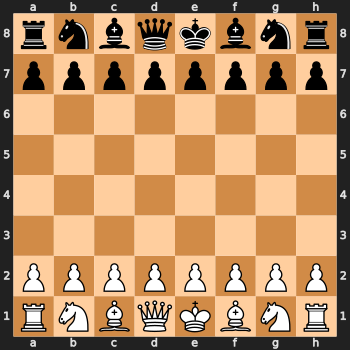


Your Turn (White). Enter move (e.g., e2e4):


In [ ]:


import chess_engine
import chess.svg
import numpy as np
import tensorflow as tf
import json
import time
from IPython.display import display, clear_output

# --- 2. CONFIGURATION ---
MODEL_PATH = "chess_engine_v1.1.keras"
MAP_PATH = "move_map.json"

# --- 3. HELPER FUNCTIONS ---

def board_to_matrix(board: chess_engine.Board):
    """Converts board to 8x8x12 matrix for the model."""
    matrix = np.zeros((8, 8, 12), dtype=np.float32)
    piece_map = board.piece_map()
    for square, piece in piece_map.items():
        row, col = divmod(square, 8)
        # Layers: 0-5 (White), 6-11 (Black)
        layer = piece.piece_type - 1 + (0 if piece.color == chess_engine.WHITE else 6)
        matrix[row, col, layer] = 1.0
    return matrix

def get_material_score(board):
    """Calculates material difference (White - Black)."""
    scores = {chess_engine.PAWN: 1, chess_engine.KNIGHT: 3, chess_engine.BISHOP: 3, chess_engine.ROOK: 5, chess_engine.QUEEN: 9, chess_engine.KING: 0}
    white_mat = sum([scores[p.piece_type] for p in board.piece_map().values() if p.color == chess_engine.WHITE])
    black_mat = sum([scores[p.piece_type] for p in board.piece_map().values() if p.color == chess_engine.BLACK])
    return white_mat - black_mat

# --- 4. SMART AI LOGIC (BLUNDER CHECKER) ---

def get_smart_move(board, model, int_to_move):
    """
    1. Predicts top 5 moves.
    2. Simulates them to see if they immediately lose material.
    3. Plays the best 'safe' move.
    """
    # Prepare input
    matrix = board_to_matrix(board)
    probs = model.predict(np.expand_dims(matrix, axis=0), verbose=0)[0]
    
    # Get Top 5 Candidate Moves
    top_idxs = probs.argsort()[::-1][:5]
    candidates = []
    
    current_score = get_material_score(board)
    ai_color = board.turn # True for White, False for Black
    
    for idx in top_idxs:
        move_str = int_to_move.get(idx)
        if not move_str: continue
        
        try:
            move = chess_engine.Move.from_uci(move_str)
            if move in board.legal_moves:
                
                # --- SIMULATION START ---
                board.push(move)
                
                # Check: Did we just hang a piece?
                # We look at the opponent's best response (1-ply lookahead)
                is_blunder = False
                
                # Optimization: Only check capturing moves for the opponent
                opponent_responses = list(board.generate_legal_captures())
                
                # If no captures, check standard score
                if not opponent_responses:
                    new_score = get_material_score(board)
                    diff = new_score - current_score
                    if not ai_color: diff = -diff # Flip if Black
                    if diff <= -3: is_blunder = True
                else:
                    # Check if any opponent capture destroys us
                    for resp in opponent_responses:
                        board.push(resp)
                        final_score = get_material_score(board)
                        diff = final_score - current_score
                        if not ai_color: diff = -diff
                        
                        # If opponent can make our score drop by 3+, it's a blunder
                        if diff <= -3: 
                            is_blunder = True
                            board.pop()
                            break
                        board.pop()
                
                board.pop() 
                # --- SIMULATION END ---

                candidates.append((move, probs[idx], is_blunder))
        except: continue
        
    candidates.sort(key=lambda x: (x[2], -x[1]))
    
    if candidates:
        best_move = candidates[0][0]
        # print debug info
        risk_label = " (RISKY)" if candidates[0][2] else ""
        print(f"AI plays: {best_move.uci()}{risk_label} | Conf: {candidates[0][1]:.1%}")
        return best_move
    
    return None

# --- 5. GAME LOOP ---

def start_game():
    print(" Loading Engine...")
    try:
        # Load Model
        model = tf.keras.models.load_model(MODEL_PATH, compile=False)
        
        # Load Vocabulary
        with open(MAP_PATH, "r") as f:
            move_list = json.load(f)
        int_to_move = {i: m for i, m in enumerate(move_list)}
        
        print("Start.")
    except Exception as e:
        print(f" Error loading files: {e}")
        return

    board = chess_engine.Board()
    
    while not board.is_game_over():
        clear_output(wait=True)
        display(chess_engine.svg.board(board=board, size=350))
        
        if board.turn == chess_engine.WHITE:
            # --- player turn ---
            print("\nYour Turn (White). Enter move (e.g., e2e4):")
            while True:
                uci = input("Move: ").strip()
                if uci == 'quit': return
                try:
                    move = chess_engine.Move.from_uci(uci)
                    if move in board.legal_moves:
                        board.push(move)
                        break
                    else:
                        print("Illegal move. Try again.")
                except:
                    print("Invalid format. Use UCI (e.g., e2e4).")
        else:
            # --- AI TURN ---
            print("\n AI is thinking...")
            # Artificial delay to make it feel like an opponent
            time.sleep(0.5) 
            
            best_move = get_smart_move(board, model, int_to_move)
            
            if best_move:
                board.push(best_move)
            else:
                print(" AI Resigns.")
                break

    clear_output(wait=True)
    display(chess_engine.svg.board(board=board, size=350))
    print(f"GAME OVER: {board.result()}")


if __name__ == "__main__":
    start_game()